In [4]:
import pandas as pd
import math
from sklearn import cross_validation, linear_model
from sklearn.linear_model import LogisticRegression
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

C:\Users\MissFlave\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Women's NCAA Tournament Predictions: Project III

Quick Links:
- [Data Importing and EDA](#Data-Importing-and-EDA)
- [Basic Logistic Regression Model](#Basic-Logistic-Regression-Model)
- [Improved Logistic Regression Model](#Improved-Logistic-Regression-Model)
- [XGboost attempt](#XGboost)
- [LightGBM](#LightGBM)
- [Model Evaluation](#Model-Evaluation)
- [Further Exploration](#Further-Exploration)


<a id='Data-Importing-and-EDA'></a>
## Data Importing and EDA

In [5]:
# Loading seed data
seeds = pd.read_csv('WNCAATourneySeeds.csv')
seeds.tail()

,Season,Seed,TeamID
1275,2017,Z12,3346
1276,2017,Z13,3195
1277,2017,Z14,3442
1278,2017,Z15,3253
1279,2017,Z16,3421


In [6]:
seeds['Seed'] = seeds['Seed'].apply(lambda seed: int(seed[1:3]))
print(seeds.tail())
print(seeds.shape)

      Season  Seed  TeamID
1275    2017    12    3346
1276    2017    13    3195
1277    2017    14    3442
1278    2017    15    3253
1279    2017    16    3421
(1280, 3)


In [7]:
# Looking at the sample submission data
sample = pd.read_csv('WSampleSubmissionStage1.csv')
print(sample.shape)

(8064, 2)


In [8]:
sample['Season'] = sample['ID'].apply(lambda ID: int(ID.split('_')[0]))
sample['TeamID'] = sample['ID'].apply(lambda ID: int(ID.split('_')[1]))
sample['OpponentID'] = sample['ID'].apply(lambda ID: int(ID.split('_')[2]))
sample.drop(['ID', 'Pred'],axis=1, inplace=True)
sample.shape

(8064, 3)

In [9]:
sample.head()

,Season,TeamID,OpponentID
0,2014,3103,3107
1,2014,3103,3113
2,2014,3103,3119
3,2014,3103,3124
4,2014,3103,3140


In [10]:
# Loading past tournament data to predict winners in the 2014-2017 tournaments

tourney_data = pd.read_csv('WNCAATourneyDetailedResults.csv')
tourney_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,138,3124,69,3201,55,N,0,28,57,...,34,3,5,17,19,12,18,4,1,18
1,2010,138,3173,67,3395,66,N,0,23,59,...,27,14,15,18,26,8,8,8,6,22
2,2010,138,3181,72,3214,37,H,0,26,57,...,15,3,8,10,21,4,16,6,4,20
3,2010,138,3199,75,3256,61,H,0,25,63,...,20,17,22,16,21,13,16,5,4,24
4,2010,138,3207,62,3265,42,N,0,24,68,...,26,11,17,16,22,9,10,3,4,12


In [11]:
tourney_data.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

## Is there a home team advantage?

In tournaments, there appears to be a neutral and home advantage. I incorporated this feature into my models.

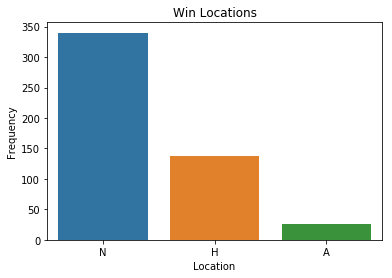

In [12]:
ax = sns.countplot(x=tourney_data['WLoc'])
ax.set_title("Win Locations")
ax.set_xlabel("Location")
ax.set_ylabel("Frequency");

In [13]:
# Dropping scores and field goals-- These would cause a "leaky model"

tourney_data.drop(['WScore', 'LScore', 'WFGM', 'LFGM'],axis=1, inplace=True)

In [14]:
tourney_data.columns

Index(['Season', 'DayNum', 'WTeamID', 'LTeamID', 'WLoc', 'NumOT', 'WFGA',
       'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl',
       'WBlk', 'WPF', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR',
       'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [15]:
# Modifying the data to designate the winners from the losers, to begin training. 

games = []
for row in tourney_data.to_dict('records'):
    game = {}
    game['Season'] =  row['Season']
    game['DayNum'] = row['DayNum']
    game['TeamID'] = row['WTeamID']
    game['OpponentID'] = row['LTeamID']
    game['Loc'] = row['WLoc']
    game['Won'] = 1
    game['FGA'] = row['WFGA']
    game['FGM3'] = row['WFGM3']
    game['FGA3'] = row['WFGA3']
    game['FTM'] = row['WFTM']
    game['FTA'] = row['WFTA']
    game['OR'] = row['WOR']
    game['DR'] = row['WDR']
    game['AST'] = row['WAst']
    game['TO'] = row['WTO']
    game['STL'] = row['WStl']
    game['BLK'] = row['WBlk']
    game['PF'] = row['WPF']
    games.append(game)
    game = {}
    game['Season'] = row['Season']
    game['DayNum'] = row['DayNum']
    game['TeamID'] = row['LTeamID']
    game['OpponentID'] = row['WTeamID']
    game['Loc'] = row['WLoc']
    game['Won']= 0
    game['FGA'] = row['LFGA']
    game['FGM3'] = row['LFGM3']
    game['FGA3'] = row['LFGA3']
    game['FTM'] = row['LFTM']
    game['FTA'] = row['LFTA']
    game['OR'] = row['LOR']
    game['DR'] = row['LDR']
    game['AST'] = row['LAst']
    game['TO'] = row['LTO']
    game['STL'] = row['LStl']
    game['BLK'] = row['LBlk']
    game['PF'] = row['LPF']
    games.append(game)
games_df = pd.DataFrame(games)
games_df.head()

,AST,BLK,DR,DayNum,FGA,FGA3,FGM3,FTA,FTM,Loc,OR,OpponentID,PF,STL,Season,TO,TeamID,Won
0,22,2,24,138,57,5,1,19,12,N,13,3201,12,6,2010,12,3124,1
1,12,1,19,138,61,34,10,5,3,N,17,3124,18,4,2010,18,3201,0
2,13,10,34,138,59,26,9,19,12,N,13,3395,14,3,2010,16,3173,1
3,8,6,26,138,73,27,8,15,14,N,18,3173,22,8,2010,8,3395,0
4,15,7,34,138,57,13,4,22,16,H,13,3214,11,10,2010,11,3181,1


In [16]:
games_df.shape

(1008, 18)

In [17]:
# Making sure there are no nulls and my data types are correct!

games_df = pd.get_dummies(games_df, columns=['Loc'])
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 20 columns):
AST           1008 non-null int64
BLK           1008 non-null int64
DR            1008 non-null int64
DayNum        1008 non-null int64
FGA           1008 non-null int64
FGA3          1008 non-null int64
FGM3          1008 non-null int64
FTA           1008 non-null int64
FTM           1008 non-null int64
OR            1008 non-null int64
OpponentID    1008 non-null int64
PF            1008 non-null int64
STL           1008 non-null int64
Season        1008 non-null int64
TO            1008 non-null int64
TeamID        1008 non-null int64
Won           1008 non-null int64
Loc_A         1008 non-null uint8
Loc_H         1008 non-null uint8
Loc_N         1008 non-null uint8
dtypes: int64(17), uint8(3)
memory usage: 136.9 KB


In [18]:
games_df.shape

(1008, 20)

In [19]:
with_team_seed = pd.merge(games_df, seeds, on = ['Season','TeamID'])
with_team_seed.rename(columns={'Seed': 'TeamSeed'}, inplace=True)
with_team_seed.shape

(1008, 21)

In [20]:
with_seeds = pd.merge(with_team_seed, seeds.rename(columns={'TeamID': 'OpponentID'}), on= ['Season', 'OpponentID'])
with_seeds.rename(columns={'Seed': 'OpponentSeed'}, inplace=True)
with_seeds.tail()

,AST,BLK,DR,DayNum,FGA,FGA3,FGM3,FTA,FTM,OR,...,STL,Season,TO,TeamID,Won,Loc_A,Loc_H,Loc_N,TeamSeed,OpponentSeed
1003,12,1,24,138,66,11,3,26,20,21,...,8,2017,7,3401,1,0,0,1,5,12
1004,17,4,26,138,53,20,7,10,8,8,...,3,2017,12,3335,0,0,0,1,12,5
1005,23,6,24,140,53,24,10,8,5,8,...,8,2017,9,3417,1,0,1,0,4,5
1006,24,7,28,138,55,17,10,18,9,9,...,11,2017,13,3417,1,0,1,0,4,13
1007,8,4,36,138,76,29,7,27,22,15,...,9,2017,6,3449,1,0,1,0,3,14


### Separating the winners from the losers to gain more insight. How important are some of these features?

In [21]:
winners = with_seeds[with_seeds['Won'] == 1]
losers = with_seeds[with_seeds['Won'] == 0]
winners.head()

,AST,BLK,DR,DayNum,FGA,FGA3,FGM3,FTA,FTM,OR,...,STL,Season,TO,TeamID,Won,Loc_A,Loc_H,Loc_N,TeamSeed,OpponentSeed
0,22,2,24,138,57,5,1,19,12,13,...,6,2010,12,3124,1,0,0,1,4,13
1,10,16,38,140,42,4,0,27,17,7,...,8,2010,21,3124,1,0,0,1,4,5
3,18,13,35,145,53,7,3,25,22,6,...,2,2010,12,3124,1,1,0,0,4,1
6,12,9,34,147,53,12,2,20,13,8,...,4,2010,12,3124,1,0,0,1,4,2
20,20,3,25,153,67,17,3,19,11,14,...,6,2010,7,3163,1,0,0,1,1,4


In [31]:
print( 'Winning seeds:', winners.TeamSeed.mean())
print( 'Losing seeds:', winners.OpponentSeed.mean())
#This makes sense, lower seeds are "better" teams!

Winning seeds: 4.007936507936508
Losing seeds: 8.617063492063492


In [24]:
winners.TO.mean()
# This also makes sense, the winners will have FEWER turnovers on average!

13.950396825396826

In [25]:
losers.TO.mean()

15.271825396825397

In [26]:
winners.FGA.mean()

59.57142857142857

In [27]:
losers.FGA.mean()

60.75198412698413

In [28]:
print(winners.FGM3.mean())
print(losers.FGM3.mean())
# There doesn't seem to be much of a difference in three pointers?

5.785714285714286
5.226190476190476


In [32]:
print(winners.DR.mean())
print(losers.DR.mean())

# Winning teams get rebounds!

28.07936507936508
21.640873015873016


In [33]:
print(winners.PF.mean())
print(losers.PF.mean())

#Losing teams commit more fouls, on average

14.890873015873016
18.0


In [34]:
print(winners.AST.mean())
print(losers.AST.mean())

# Winners make more assists per game on average 

15.948412698412698
11.26388888888889


### How do the seed rankings influence the stats?

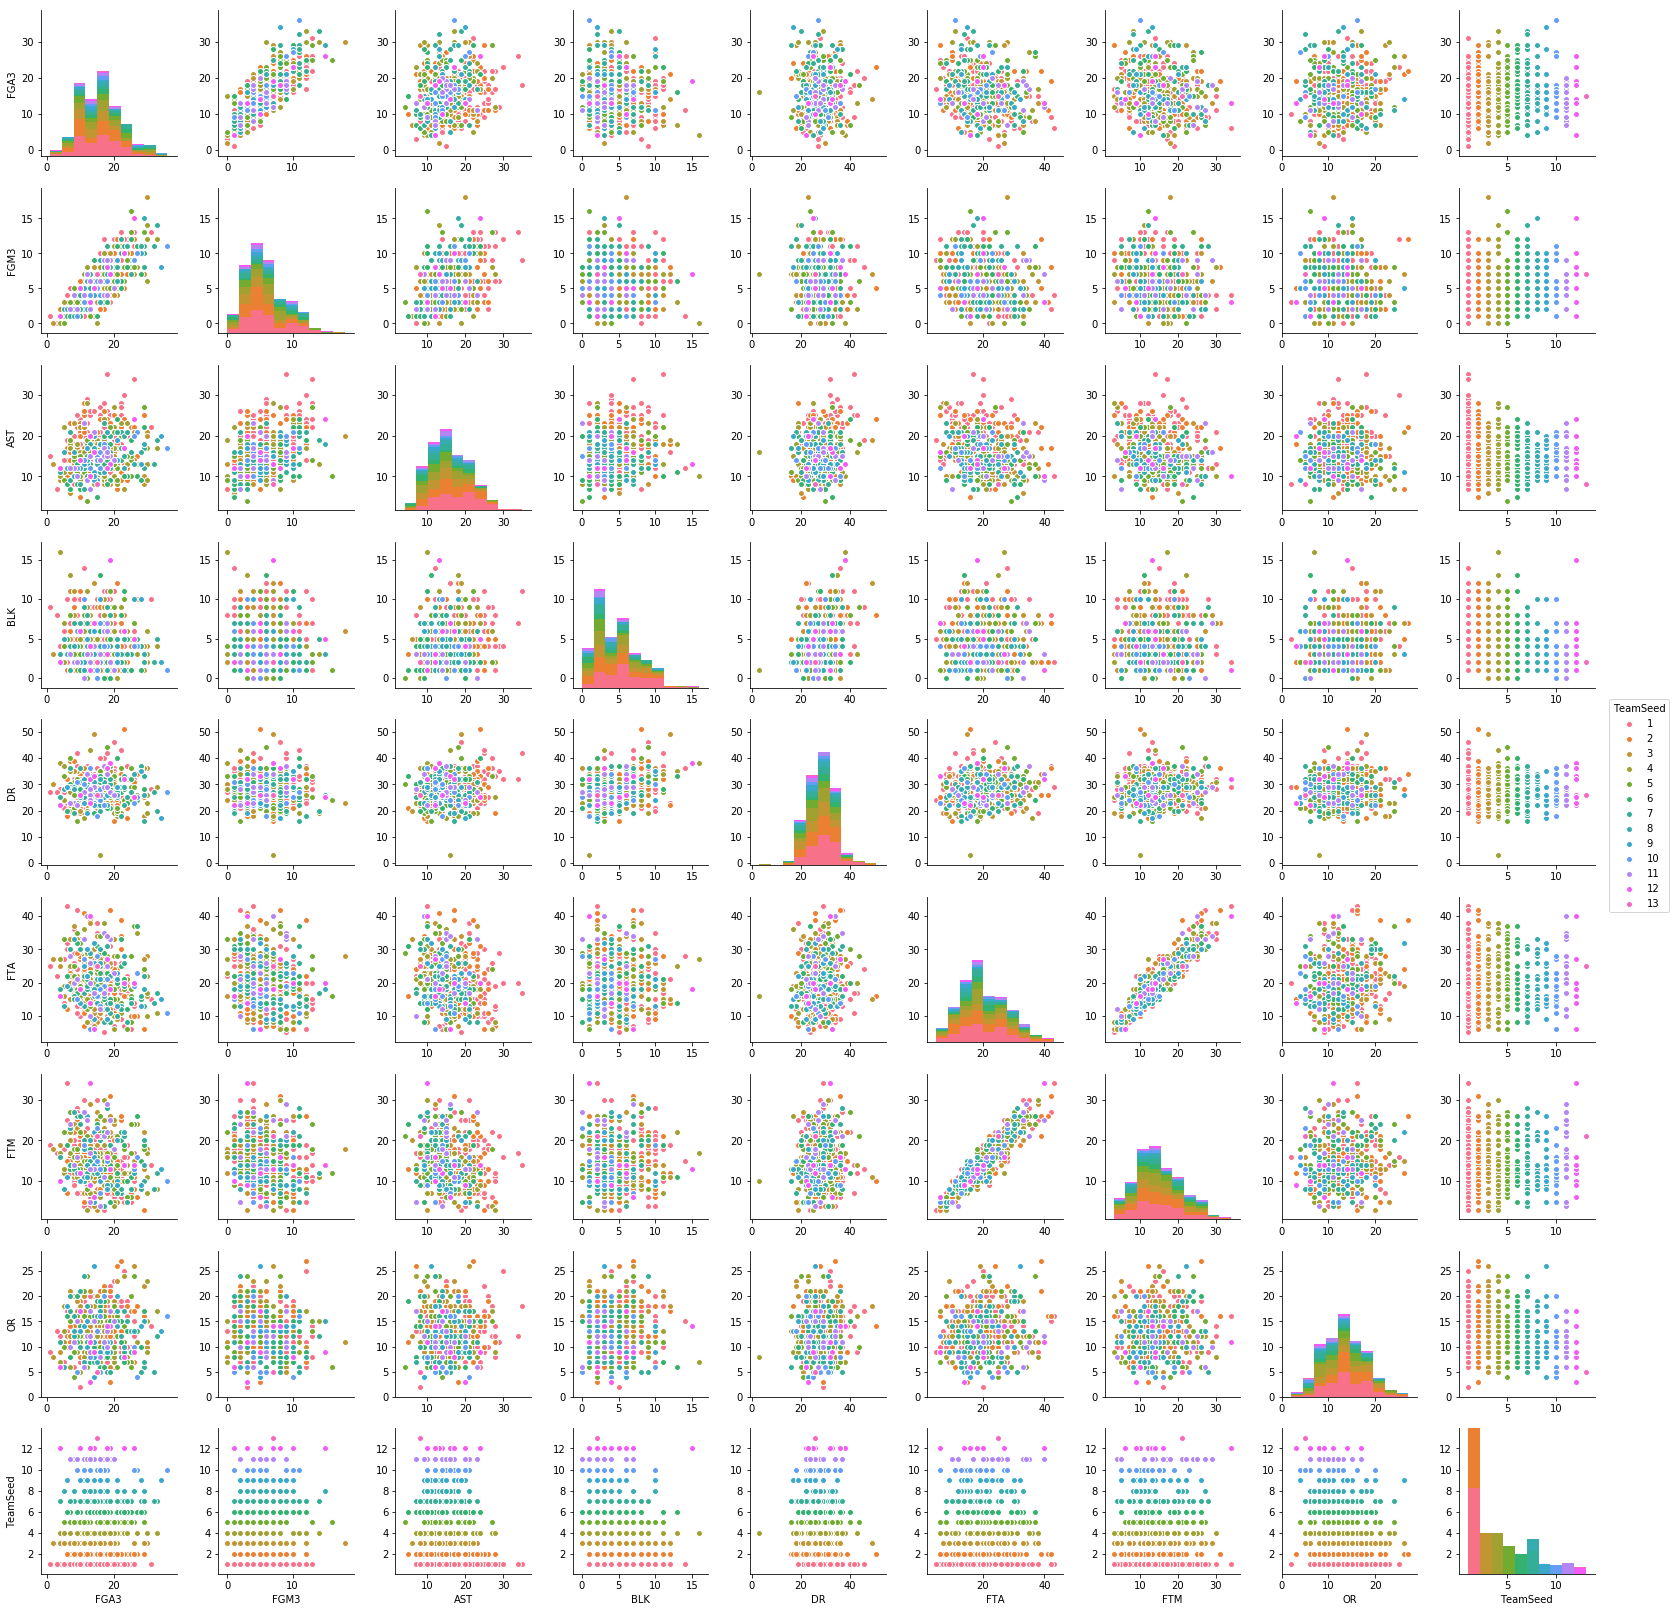

In [35]:
sns.pairplot(winners[['FGA3',
                        'FGM3',
                        'AST',
                          'BLK',
                          'DR',
                          'FTA',
                          'FTM',
                          'OR',
                        'TeamSeed',]], hue='TeamSeed')

Text(0.5,1,'Tourney Seeds')

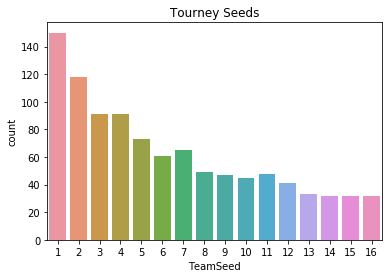

In [36]:
ax2 = sns.countplot(x=with_seeds['TeamSeed'])
ax2.set_title("Tourney Seeds")

In [37]:
train = with_seeds.loc[with_seeds['Season'] < 2014, :]
test = with_seeds.loc[with_seeds['Season'] >= 2014, :].copy()
test.Season.value_counts()

2017    126
2016    126
2015    126
2014    126
Name: Season, dtype: int64

In [38]:
train.Season.value_counts()

2013    126
2012    126
2011    126
2010    126
Name: Season, dtype: int64

## What features are correlated with tournament wins?

Surprisingly, assists, defensive rebounds, and personal fouls are more correlated with winning than I previously thought.

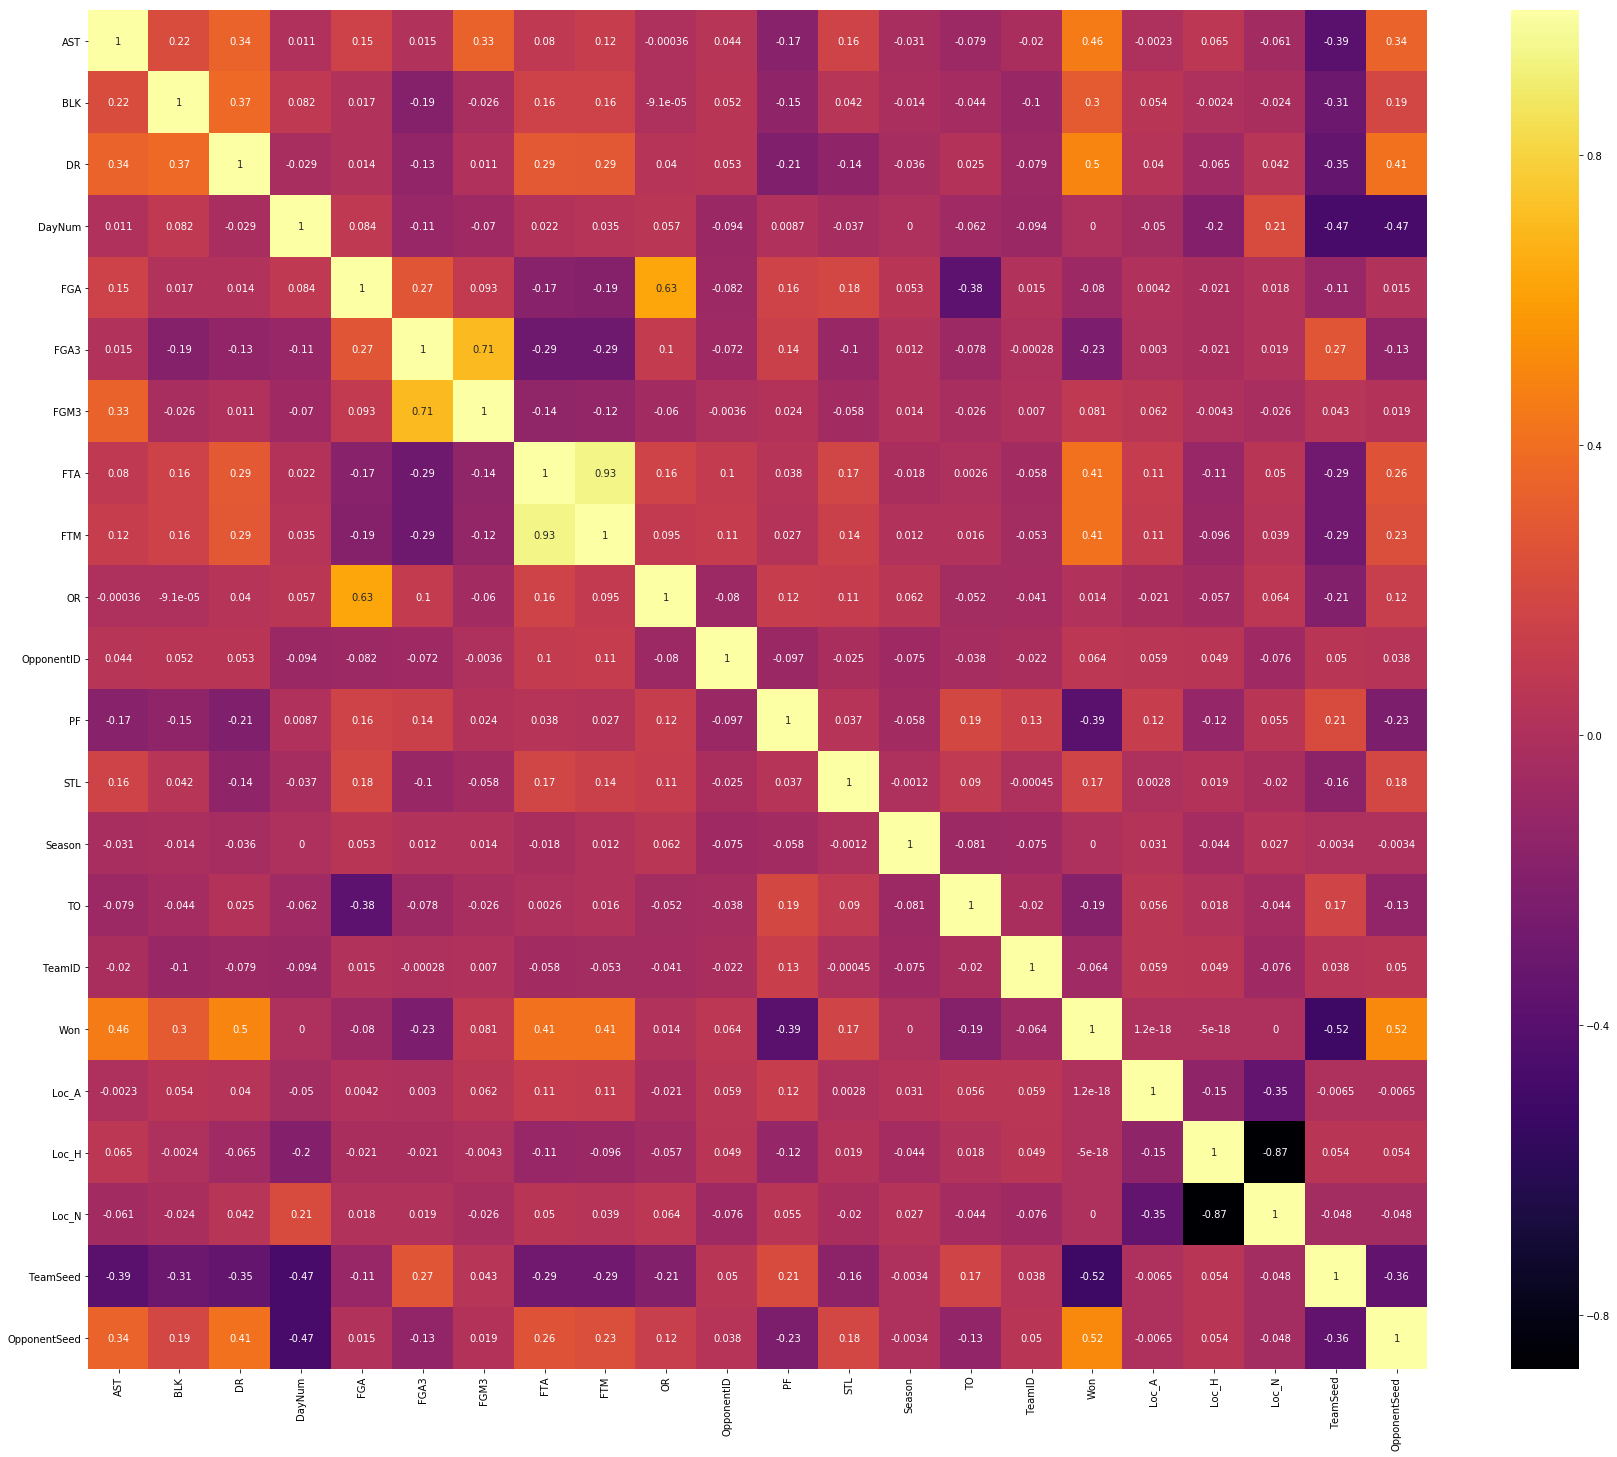

In [39]:
corr = train.corr()
# Set up the matplot figure
f,ax = plt.subplots(figsize=(30,25))
#Draw the heatmap using seaborn
sns.heatmap(corr, cmap='inferno', annot=True)

In [40]:
# Subsetting the training set to only include the winners
winners = train[train.Won==1]

In [41]:
winners.TeamSeed.mean()
# Intuitively, this makes sense. The winning teams have lower seeds (on average)

3.984126984126984

In [42]:
winners.OpponentSeed.mean()

8.615079365079366

<a id='Basic-Logistic-Regression-Model'></a>
## Basic Logistic Regression model

In [43]:
features = ['AST', 'BLK', 'DR', 'DayNum', 'FGA', 'FGA3', 'FGM3', 'FTA', 'FTM', 'OR',
       'OpponentID', 'PF', 'STL', 'Season', 'TO', 'TeamID', 'Loc_A',
       'Loc_H', 'Loc_N', 'TeamSeed', 'OpponentSeed']

lr = LogisticRegression()
lr.fit(train[features], train['Won'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
pred = lr.predict_proba(test[features])[:, 1]

In [45]:
test['Pred'] = pred
test.shape

(504, 23)

In [46]:
test['ID'] = test.apply(lambda row: '{}_{}_{}'.format(int(row['Season']), int(row['TeamID']), int(row['OpponentID'])), axis=1)

In [47]:
sub = pd.read_csv('WSampleSubmissionStage1.csv')

In [48]:
all_predictions = pd.merge(sub.drop('Pred', axis = 1), test[['ID', 'Pred']], how='left', on=['ID']).fillna(0.5)

In [49]:
print(all_predictions.shape)
print(all_predictions.head())
print(all_predictions.tail())

(8064, 2)
               ID  Pred
0  2014_3103_3107   0.5
1  2014_3103_3113   0.5
2  2014_3103_3119   0.5
3  2014_3103_3124   0.5
4  2014_3103_3140   0.5
                  ID  Pred
8059  2017_3443_3452   0.5
8060  2017_3443_3453   0.5
8061  2017_3449_3452   0.5
8062  2017_3449_3453   0.5
8063  2017_3452_3453   0.5


In [50]:
sample.shape
# Oh look, they match!!

(8064, 3)

In [51]:
#aall_predictions.to_csv('DetailedResultsModel.csv', index=False)
# This gave me a ~0.48 log loss score on Kaggle 

<a id='Improved-Logistic-Regression-Model'></a>
## Improved Logistic Regression Model...

In [52]:
from sklearn.linear_model import LogisticRegressionCV

log_clf = LogisticRegressionCV(cv = 5,Cs=8,n_jobs=4,scoring="neg_log_loss")

log_clf.fit(train[features], train['Won'])

LogisticRegressionCV(Cs=8, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=4, penalty='l2', random_state=None,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)

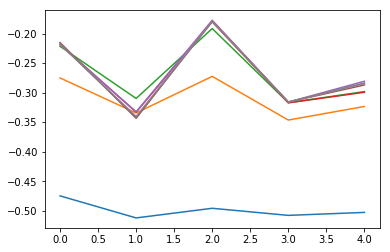

In [54]:
 import matplotlib.pyplot as plt
ax = plt.plot(log_clf.scores_[1])
# plt.ylabel('some numbers')
plt.show()

In [55]:
score = log_clf.score(test[features], test['Won'])
print(score)

0.8869047619047619


In [56]:
from sklearn.metrics import log_loss
log_loss(test['Won'], pred)

#This log loss is pretty good. The Stage 1 Kaggle competition log loss "good score" was about 0.45

0.2543349665392492

<a id='XGboost'></a>
## My attempts at installing XGboost == fail :( Not a Windows friendly package

In [57]:
#!pip install xgboost

# from xgboost import XGBClassifier

#model_xgb = XGBClassifier()
#model_xgb.fit(train[features], train['Won'])

#pd.Series(model_xgb.feature_importances_,index=list(train[features].columns.values)).sort_values(ascending=True).plot(kind='barh',figsize=(12,18),title='XGBOOST FEATURE IMPORTANCE')

<a id='LightGBM'></a>
## Following Brice's reccomendation, I installed LightGBM (Microsoft's version of XGboost)

I modified code from this LightGBM github example: https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py

In [58]:
import json
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

try:
    import cPickle as pickle
except:
    import pickle

In [59]:
num_train, num_feature = train[features].shape

In [60]:
# Loading Data into LGB Datasets:

lgb_train = lgb.Dataset(train[features], train['Won'], free_raw_data=False)
lgb_eval = lgb.Dataset(test[features], test['Won'], reference=lgb_train, free_raw_data=False)

# Setting Params
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# generate a feature name
feature_name = ['feature_' + str(col) for col in range(num_feature)]

print('Start training...')
# feature_name and categorical_feature
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_train,  # eval training data
                feature_name=feature_name)

# check feature name
print('Finish first 10 rounds...')
print('7th feature name is:', repr(lgb_train.feature_name[6]))

Start training...
[1]	training's binary_logloss: 0.6683
[2]	training's binary_logloss: 0.645547
[3]	training's binary_logloss: 0.624279
[4]	training's binary_logloss: 0.604894
[5]	training's binary_logloss: 0.587205
[6]	training's binary_logloss: 0.570224
[7]	training's binary_logloss: 0.554456
[8]	training's binary_logloss: 0.540594
[9]	training's binary_logloss: 0.526297
[10]	training's binary_logloss: 0.512102
Finish first 10 rounds...
7th feature name is: 'feature_6'


In [61]:
# save model to file
gbm.save_model('model.txt')

# dump model to json (and save to file)
print('Dump model to JSON...')
model_json = gbm.dump_model()

with open('model.json', 'w+') as f:
    json.dump(model_json, f, indent=4)

# feature names
print('Feature names:', gbm.feature_name())

# feature importances
print('Feature importances:', list(gbm.feature_importance()))

# load model to predict
print('Load model to predict')
bst = lgb.Booster(model_file='model.txt')
# can only predict with the best iteration (or the saving iteration)
y_pred = bst.predict(test[features])
# eval with loaded model
print('The rmse of loaded model\'s prediction is:', mean_squared_error(test['Won'], y_pred) ** 0.5)

# dump model with pickle
with open('model.pkl', 'wb') as fout:
    pickle.dump(gbm, fout)
# load model with pickle to predict
with open('model.pkl', 'rb') as fin:
    pkl_bst = pickle.load(fin)
# can predict with any iteration when loaded in pickle way
y_pred = pkl_bst.predict(test[features], num_iteration=7)
# eval with loaded model
print('The rmse of pickled model\'s prediction is:', mean_squared_error(test['Won'], y_pred) ** 0.5)

# continue training
# init_model accepts:
# 1. model file name
# 2. Booster()
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model='model.txt',
                valid_sets=lgb_eval)

print('Finish 10 - 20 rounds with model file...')

# decay learning rates
# learning_rates accepts:
# 1. list/tuple with length = num_boost_round
# 2. function(curr_iter)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                learning_rates=lambda iter: 0.05 * (0.99 ** iter),
                valid_sets=lgb_eval)

print('Finish 20 - 30 rounds with decay learning rates...')

# change other parameters during training
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                valid_sets=lgb_eval,
                callbacks=[lgb.reset_parameter(bagging_fraction=[0.7] * 5 + [0.6] * 5)])

print('Finish 30 - 40 rounds with changing bagging_fraction...')


# self-defined objective function
# f(preds: array, train_data: Dataset) -> grad: array, hess: array
# log likelihood loss
def loglikelood(preds, train_data):
    labels = train_data.get_label()
    preds = 1. / (1. + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1. - preds)
    return grad, hess


# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, value: array, is_higher_better: bool
# binary error
def binary_error(preds, train_data):
    labels = train_data.get_label()
    return 'error', np.mean(labels != (preds > 0.5)), False


gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                fobj=loglikelood,
                feval=binary_error,
                valid_sets=lgb_eval)

print('Finish 40 - 50 rounds with self-defined objective function and eval metric...')

print('Start a new training job...')


# callback
def reset_metrics():
    def callback(env):
        lgb_eval_new = lgb.Dataset(test[features], test['Won'], reference=lgb_train)
        if env.iteration - env.begin_iteration == 5:
            print('Add a new valid dataset at iteration 5...')
            env.model.add_valid(lgb_eval_new, 'new valid')
    callback.before_iteration = True
    callback.order = 0
    return callback


gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_train,
                callbacks=[reset_metrics()])

print('Finish first 10 rounds with callback function...')

Dump model to JSON...
Feature names: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20']
Feature importances: [17, 2, 17, 8, 2, 3, 3, 14, 8, 2, 6, 8, 7, 2, 5, 2, 0, 0, 0, 18, 21]
Load model to predict
The rmse of loaded model's prediction is: 0.4249159710146615
The rmse of pickled model's prediction is: 0.44208743347375073
[11]	valid_0's binary_logloss: 0.539967
[12]	valid_0's binary_logloss: 0.53151
[13]	valid_0's binary_logloss: 0.524103
[14]	valid_0's binary_logloss: 0.516251
[15]	valid_0's binary_logloss: 0.506765
[16]	valid_0's binary_logloss: 0.497804
[17]	valid_0's binary_logloss: 0.490296
[18]	valid_0's binary_logloss: 0.48209
[19]	valid_0's binary_logloss: 0.474819
[20]	valid_0's binary_logloss: 0.46813
Finish 10 - 20 rounds with model file...
[21]

C:\Users\MissFlave\Anaconda\lib\site-packages\lightgbm\basic.py:729: UserWarning: The prediction of init_model will be overrided by init_score.
  warnings.warn("The prediction of init_model will be overrided by init_score.")


<a id='Model-Evaluation'></a>
## Model Evaluation:

I chose LightGBM because I'm assuming it will do better in the Kaggle competition. Also, it has tons of parameters to tune, allowing for customization and improvment. 

"As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and is the most important criterion for fit if the main purpose of the model is prediction."

The rmse of loaded model's prediction is: 0.3468741532329249
The rmse of pickled model's prediction is: 0.44208743347375073



<a id='Further-Exploration'></a>
## Further Exploration
See 2018 Predictions Notebook: [WNCAA_2018_Predictions]('WNCAA_2018_Predictions.ipynb')